In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

In [2]:
current_directory = os.getcwd()
print(current_directory)
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

D:\boshi\GitHub\kears_learning\training_project\Natural Language Processing with Disaster Tweets


In [3]:
print(train.columns)
train.head(5)

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test.sample(5)

,id,keyword,location,text
633,2065,casualty,"Pasadena, CA",#LegalJobs Litigation Attorney in Scottsdale A...
1670,5637,flooding,NaN,Nigeria warned against massiveåÊflooding http:...
2642,8826,sirens,Bristol,sleeping with sirens are so irrelevant
253,824,battle,Gislaved,After a long battle @Spurs Matt Bonner took ca...
2509,8358,ruin,NaN,My sister really always has to ruin my life.


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
train_label = train.target.to_numpy()

In [7]:
y_train = train_label.reshape(-1)

In [8]:
train.drop(['id', 'keyword', 'location', 'target'], axis=1, inplace=True)
test.drop(['id', 'keyword', 'location'], axis=1, inplace=True)

In [9]:
train = train.to_numpy()
test = test.to_numpy()
X_train = train.reshape(-1)
X_test = test.reshape(-1)

In [10]:
print(X_train[0])

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all


## Normalization

In [11]:
import re
import string

def clean_tweet(tweet):

  #apostrophe
  tweet = re.sub(r'\x89Ûª', "'", tweet)
  tweet = re.sub(r'\x89Û÷', "'", tweet)

  #quotation
  tweet = re.sub(r'\x89ÛÏ', '"', tweet)
  tweet = re.sub(r'\x89Û\x9d', '"', tweet)

  #hyphen
  tweet = re.sub(r'\x89ÛÒ', '-', tweet)
  tweet = re.sub(r'\x89ÛÓ', '—', tweet)

  #euro
  tweet = re.sub(r'\x89âÂ', '€', tweet)

  #ellipsis
  tweet = re.sub(r'\x89Û_', '...', tweet)

  #amp
  tweet = re.sub(r'&', 'and', tweet)


  #bullet
  tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
  tweet = re.sub(r'\x89Û¢', '', tweet)


  #no idea
  tweet = re.sub(r'\x89ã¢', '', tweet)
  tweet = re.sub(r"å_", "", tweet)


  #other
  tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
  tweet = re.sub(r"åÊ", "", tweet)
  tweet = re.sub(r"åÈ", "", tweet)
  tweet = re.sub(r"JapÌ_n", "Japan", tweet)
  tweet = re.sub(r"Ì©", "e", tweet)
  tweet = re.sub(r"å¨", "", tweet)
  tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
  tweet = re.sub(r"åÇ", "", tweet)
  tweet = re.sub(r"å£3million", "3 million ", tweet)
  tweet = re.sub(r"åÀ", "", tweet)

  return tweet

def find_URL(text):
  url = re.compile(r'https?://\S+|www\.\S+')

  return url.findall(text)

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html(text):
  html=re.compile(r'<.*?>')
  return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)



In [12]:
def custom_standardization(input_data):
    r = clean_tweet(input_data)
    r = remove_URL(r)
    r = remove_html(r)
    r = remove_emoji(r)
    r = str.lower(r)
    return r

In [13]:

def normalization(tweets):
    result = []
    for tweet in tweets:
        result.append(custom_standardization(tweet))
    return result

X_train = normalization(X_train)
X_test = normalization(X_test)


In [14]:
# Model constants.
max_features = 20000
embedding_dim = 128
max_len = 500

## Loading models from TensorFlow Hub

In [15]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [16]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [17]:
text_test = [X_test[0]]
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2074 3047 1037 6659 2482 5823  102    0    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [18]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [19]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.9227769   0.9952275  -0.12353608  0.01983948  0.15176736  0.19147924
  0.986091   -0.9554271  -0.3967298  -0.99980485  0.05940795 -0.96211916]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[ 0.02985228 -0.46668398  0.95864594 ... -1.5772667   0.88836426
   0.7641778 ]
 [-0.89425933  0.15325439  0.09188204 ... -0.10191652 -0.39057043
   1.0983611 ]
 [ 0.5345988  -0.9302995  -0.02565105 ...  0.4194027  -1.1859672
   1.0559411 ]
 ...
 [ 0.1068064  -0.54192615 -0.21300927 ... -0.10006644  0.59518737
   0.3988758 ]
 [-0.21109122 -0.1774855   0.2180382  ... -0.5134322   0.94635355
   0.20494863]
 [ 0.44559154 -0.4911858  -0.04577646 ... -0.35292563  1.2446221
   0.12057008]]


In [20]:
## Spilt Data to train and validation
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [21]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 128
seed = 42
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.batch(batch_size=batch_size).cache().prefetch(buffer_size=AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
val_ds = val_ds.batch(batch_size=batch_size).cache().prefetch(buffer_size=AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices(X_test)
test_ds = test_ds.batch(batch_size=batch_size).cache().prefetch(buffer_size=AUTOTUNE)

In [22]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label}')

Review: b'sioux city fire officials believe bridge collapse lead to cement truck roll over - siouxland matters: siouxlan... '
Label : 1
Review: b'i strongly support our military andamp; their families just not the cock suckers in dc they work for'
Label : 0
Review: b'@lucysforsale funny cause my dumb ass was the young one to get n trouble the most lol'
Label : 1


In [23]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [24]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

print(steps_per_epoch, num_train_steps, num_warmup_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

48 480 48


In [25]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  model = tf.keras.Model(text_input, net)
  model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
  return model


In [26]:

classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(bert_raw_result)

tf.Tensor([[-0.7816963]], shape=(1, 1), dtype=float32)


In [27]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

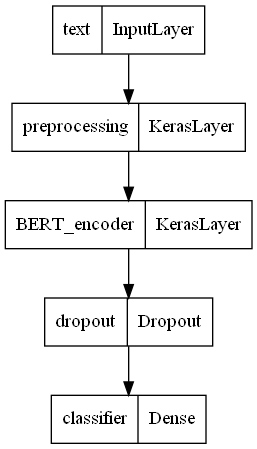

In [28]:
tf.keras.utils.plot_model(classifier_model)

In [29]:
from keras.callbacks import *

lr = ReduceLROnPlateau(monitor="val_binary_accuracy", mode='max', factor=0.7, patience=4, verbose=False)
es = EarlyStopping(monitor='val_binary_accuracy',mode='max', patience=10, verbose=False,restore_best_weights=True)

history = classifier_model.fit(
    x=train_ds,
    validation_data=val_ds,
    epochs=epochs,

    )

Epoch 1/10
48/48 [==============================] - 73s 1s/step - loss: 0.6562 - binary_accuracy: 0.6481 - val_loss: 0.4717 - val_binary_accuracy: 0.7814
Epoch 2/10
48/48 [==============================] - 69s 1s/step - loss: 0.4450 - binary_accuracy: 0.7961 - val_loss: 0.4226 - val_binary_accuracy: 0.8207
Epoch 3/10
48/48 [==============================] - 69s 1s/step - loss: 0.3807 - binary_accuracy: 0.8345 - val_loss: 0.4221 - val_binary_accuracy: 0.8240
Epoch 4/10
48/48 [==============================] - 69s 1s/step - loss: 0.3417 - binary_accuracy: 0.8522 - val_loss: 0.4346 - val_binary_accuracy: 0.8280
Epoch 5/10
48/48 [==============================] - 69s 1s/step - loss: 0.3018 - binary_accuracy: 0.8739 - val_loss: 0.4517 - val_binary_accuracy: 0.8253
Epoch 6/10
48/48 [==============================] - 70s 1s/step - loss: 0.2759 - binary_accuracy: 0.8828 - val_loss: 0.4654 - val_binary_accuracy: 0.8240
Epoch 7/10
48/48 [==============================] - 70s 1s/step - loss: 0.25

In [30]:
loss, accuracy = classifier_model.evaluate(train_ds)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

48/48 [==============================] - 48s 1s/step - loss: 0.1635 - binary_accuracy: 0.9409
Loss: 0.16351614892482758
Accuracy: 0.9408866763114929


In [31]:
def plot_hist(history_dict):
    history_dict = history.history
    print(history_dict.keys())

    acc = history_dict['binary_accuracy']
    val_acc = history_dict['val_binary_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)
    fig = plt.figure(figsize=(10, 6))
    fig.tight_layout()

    plt.subplot(2, 1, 1)
    # r is for "solid red line"
    plt.plot(epochs, loss, 'r', label='Training loss')
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    # plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    return

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


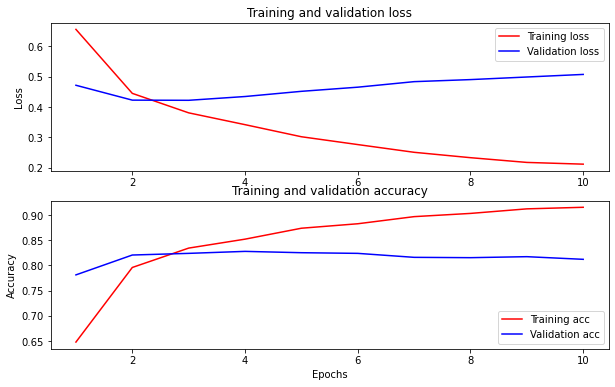

In [32]:
plot_hist(history_dict=history)

In [33]:
dataset_name = 'nlp_disaster_tweets'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./nlp_disaster_tweets_bert\assets


INFO:tensorflow:Assets written to: ./nlp_disaster_tweets_bert\assets


In [34]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [35]:
examples = np.array(X_test)

examples = examples[np.random.choice(100, 5)]
examples

array(["not a diss song. people will take 1 thing and run with it. smh it's an eye opener though. he is about 2 set the game ablaze @cyhitheprynce",
       "@jadeformkx you should be happy i don't use aftershock. that variation counters your play style hard.",
       "no i don't like cold!",
       'typhoon soudelor kills 28 in china and taiwan',
       "#previouslyondoyintv: toke makinwa's marriage crisis sets nigerian twitter ablaze... "],
      dtype='<U157')

In [36]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()

reloaded_results = reloaded_model(tf.constant(examples))
original_results = classifier_model(tf.constant(examples))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: not a diss song. people will take 1 thing and run with it. smh it's an eye opener though. he is about 2 set the game ablaze @cyhitheprynce : score: -4.199847
input: @jadeformkx you should be happy i don't use aftershock. that variation counters your play style hard. : score: -5.580878
input: no i don't like cold!          : score: -2.273806
input: typhoon soudelor kills 28 in china and taiwan : score: 6.490123
input: #previouslyondoyintv: toke makinwa's marriage crisis sets nigerian twitter ablaze...  : score: 2.575468

Results from the model in memory:
input: not a diss song. people will take 1 thing and run with it. smh it's an eye opener though. he is about 2 set the game ablaze @cyhitheprynce : score: -4.199847
input: @jadeformkx you should be happy i don't use aftershock. that variation counters your play style hard. : score: -5.580878
input: no i don't like cold!          : score: -2.273806
input: typhoon soudelor kills 28 in china and taiwan 

## Predict test data

In [37]:
y_pred = classifier_model.predict(X_test).squeeze()

In [38]:
sub_data = pd.read_csv("data/sample_submission.csv")

In [39]:
sub_data.target = (y_pred > 0.5).astype(int)

In [40]:
sub_data

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [41]:
sub_data.to_csv('submission.csv', index=False)